In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from pathlib import Path 
import glob
import os
from rdkit import DataStructs
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from rdkit.Chem import Draw, Descriptors, RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [227]:
path = 'data/balanced_data'
files = Path(path).glob('*.csv') 
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    d = pd.read_csv(filename, index_col=None, header=0)
    frames.append(d)
df = pd.concat(frames, axis=0, ignore_index=True)
df = df.drop_duplicates(subset = ['target'])

In [228]:
path = 'data/balanced_bin_data'
files = Path(path).glob('*.csv') 
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    d = pd.read_csv(filename, index_col=None, header=0)
    frames.append(d)
df_bin = pd.concat(frames, axis=0, ignore_index=True)
df_bin = df_bin.drop_duplicates(subset = ['target'])  

In [229]:
path = 'data/control'
files = Path(path).glob('*.csv') 
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    d = pd.read_csv(filename, index_col=None, header=0)
    frames.append(d)
df_con = pd.concat(frames, axis=0, ignore_index=True)
df_con = df_con.drop_duplicates(subset = ['target'])  

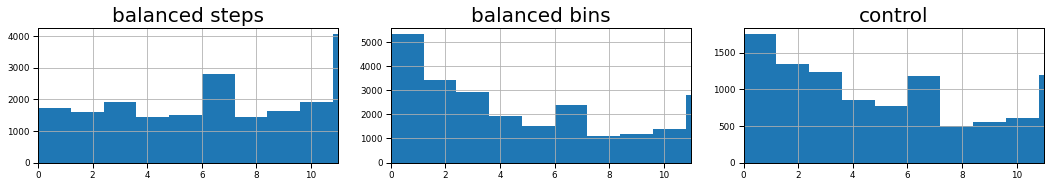

In [231]:
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax0.hist(df.number_of_steps)
ax0.set_title('balanced steps')
ax1.hist(df_bin.number_of_steps)
ax1.set_title('balanced bins')
ax2.hist(df_con.number_of_steps)
ax2.set_title('control')
ax0.grid()
ax1.grid()
ax2.grid()
ax0.set_xlim(0, 11)
ax1.set_xlim(0, 11)
ax2.set_xlim(0, 11)
fig.tight_layout()
plt.show()

In [232]:
df = df[df.number_of_steps <= 10]
df = df[df.number_of_steps > 0]
df = df.reset_index(drop=True)
len(df) # 15918  

15918

In [233]:
df_bin = df_bin[df_bin.number_of_steps <= 10]
df_bin = df_bin[df_bin.number_of_steps > 0]
df_bin = df_bin.reset_index(drop=True)
len(df_bin)

21153

In [234]:
df_con = df_con[df_con.number_of_steps <= 10]
df_con = df_con[df_con.number_of_steps > 0]
df_con = df_con.reset_index(drop=True)
len(df_con)

8775

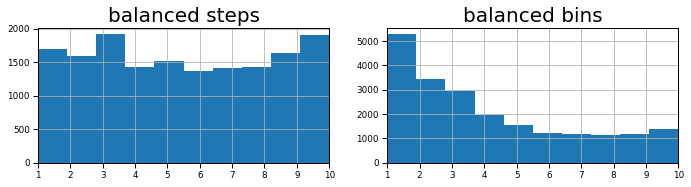

In [235]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax0.hist(df.number_of_steps)
ax0.set_title('balanced steps')
ax1.hist(df_bin.number_of_steps)
ax1.set_title('balanced bins')
ax0.grid()
ax1.grid()
ax0.set_xlim(1, 10)
ax1.set_xlim(1, 10)
fig.tight_layout()
plt.show()

In [236]:
df['steps_bins'] = pd.cut(df['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df.steps_bins.value_counts()

3    6378
2    4324
1    3514
0    1702
Name: steps_bins, dtype: int64

In [237]:
df_bin['steps_bins'] = pd.cut(df_bin['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df_bin.steps_bins.value_counts()

1    6372
0    5266
3    4832
2    4683
Name: steps_bins, dtype: int64

In [238]:
df_con['steps_bins'] = pd.cut(df_con['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df_con.steps_bins.value_counts()

1    2586
2    2234
3    2227
0    1728
Name: steps_bins, dtype: int64

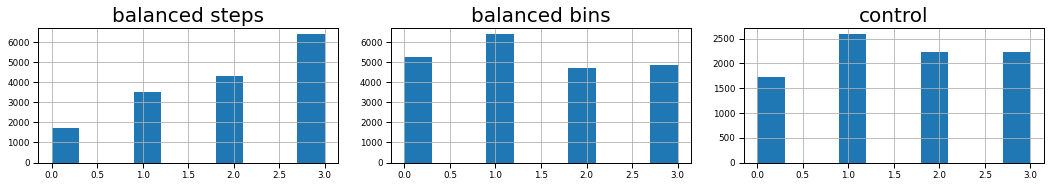

In [239]:
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax0.hist(df.steps_bins)
ax0.set_title('balanced steps')
ax1.hist(df_bin.steps_bins)
ax1.set_title('balanced bins')
ax2.hist(df_con.steps_bins)
ax2.set_title('control')
ax0.grid()
ax1.grid()
ax2.grid()
fig.tight_layout()
plt.show()

In [240]:
sc = SCScorer()
sc.restore(os.path.join('/home/zumrovad/DP/scscore',
                        'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
# (r'C:\Users\domiz\Documents\Python\DP\scscore', 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from /home/zumrovad/DP/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


In [241]:
syba = [sy.predict(smile) for smile in df.target]
df = df.assign(syba=syba)
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df.target]
df = df.assign(sascore=sascore)
scscore = [sc.get_score_from_smi(smile)[1] for smile in df.target]
df = df.assign(scscore=scscore)
mols = [Chem.MolFromSmiles(m) for m in df.target]
df = df.assign(mol=mols)
df['MolWt'] = df.mol.apply(Descriptors.MolWt)
df['MolLogP'] = df.mol.apply(Descriptors.MolLogP)
df['NumHAccept'] = df.mol.apply(Descriptors.NumHAcceptors)
df['NumHDonors'] = df.mol.apply(Descriptors.NumHDonors)

In [242]:
syba = [sy.predict(smile) for smile in df_bin.target]
df_bin = df_bin.assign(syba=syba)
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df_bin.target]
df_bin = df_bin.assign(sascore=sascore)
scscore = [sc.get_score_from_smi(smile)[1] for smile in df_bin.target]
df_bin = df_bin.assign(scscore=scscore)
mols = [Chem.MolFromSmiles(m) for m in df_bin.target]
df_bin = df_bin.assign(mol=mols)
df_bin['MolWt'] = df_bin.mol.apply(Descriptors.MolWt)
df_bin['MolLogP'] = df_bin.mol.apply(Descriptors.MolLogP)
df_bin['NumHAccept'] = df_bin.mol.apply(Descriptors.NumHAcceptors)
df_bin['NumHDonors'] = df_bin.mol.apply(Descriptors.NumHDonors)

In [243]:
syba = [sy.predict(smile) for smile in df_con.target]
df_con = df_con.assign(syba=syba)
sascore = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df_con.target]
df_con = df_con.assign(sascore=sascore)
scscore = [sc.get_score_from_smi(smile)[1] for smile in df_con.target]
df_con = df_con.assign(scscore=scscore)
mols = [Chem.MolFromSmiles(m) for m in df_con.target]
df_con = df_con.assign(mol=mols)
df_con['MolWt'] = df_con.mol.apply(Descriptors.MolWt)
df_con['MolLogP'] = df_con.mol.apply(Descriptors.MolLogP)
df_con['NumHAccept'] = df_con.mol.apply(Descriptors.NumHAcceptors)
df_con['NumHDonors'] = df_con.mol.apply(Descriptors.NumHDonors)

<Figure size 1080x1080 with 0 Axes>

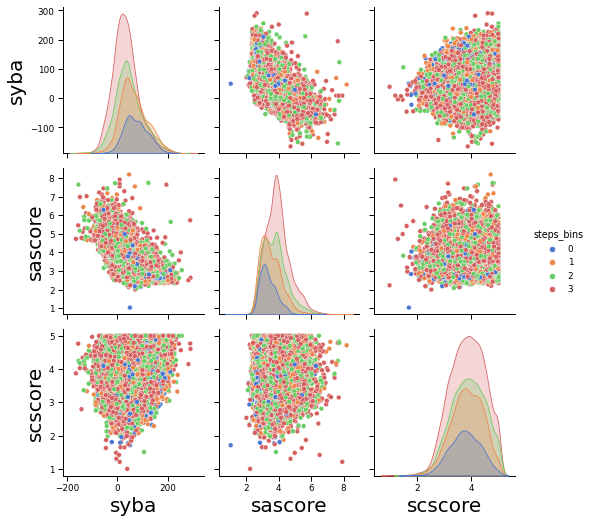

In [244]:
plt.figure(figsize=(15,15))
#sns.set_context("notebook", rc={"axes.labelsize": 16}) #"poster", font_scale=1.1
sns.pairplot(df[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins', palette = 'muted') #height=2
#plt.savefig("set_context_notebook_Seaborn_pairplot.png", format='png',dpi=150)

<Figure size 1080x1080 with 0 Axes>

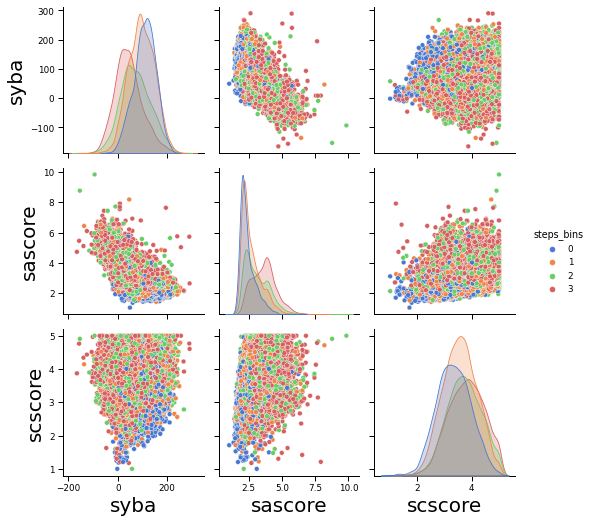

In [245]:
plt.figure(figsize=(15,15))
sns.pairplot(df_bin[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins', palette = 'muted') 

<Figure size 1080x1080 with 0 Axes>

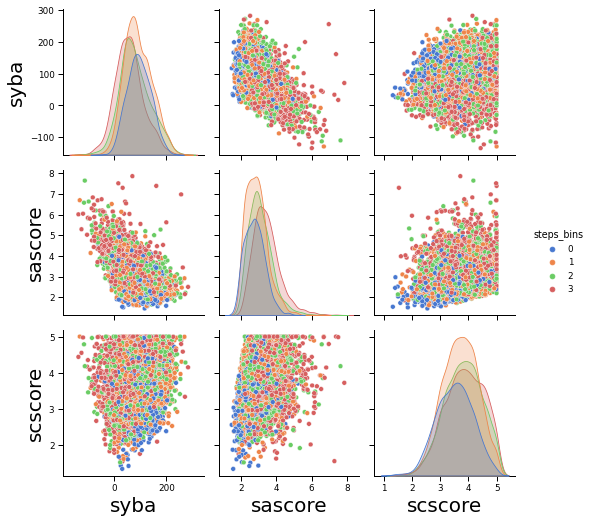

In [246]:
plt.figure(figsize=(15,15))
sns.pairplot(df_con[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins', palette = 'muted') 

In [247]:
filepath = Path('data/7Mfinal_balanced_steps.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath, index=False) 

filepath = Path('data/7Mfinal_balanced_bins.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_bin.to_csv(filepath, index=False) 

filepath = Path('data/7Mfinal_control.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_con.to_csv(filepath, index=False) 

# Scaffold filter

In [2]:
df = pd.read_csv('data/7Mfinal_balanced_steps.csv')
df_bin = pd.read_csv('data/7Mfinal_balanced_bins.csv')
df_con = pd.read_csv('data/7Mfinal_control.csv')

In [3]:
def scaffold_filter(smil0, smil1, group0, group1, df):
    treshold_head = 1.8 # 1.7, 1.5, 1.8, 2, 3, 5
    treshold_tail = 0.56 # 0.59, 0.67, 0.56, 0,5 0.33, 0.2
    scaffolds_merge = smil0.merge(smil1, left_on='index', right_on='index')
    scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
    scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)
    idx = []
    for i in scaffolds_merge[scaffolds_merge['prob_ratio'] < treshold_tail]['index']:
        ids = df.index[df.steps_bins == group0][df[df.steps_bins == group0].scaf3_smiles == i].tolist()
        for i in ids:
            idx.append(i)
    for i in scaffolds_merge[scaffolds_merge['prob_ratio'] > treshold_head]['index']:
        ids = df.index[df.steps_bins == group1][df[df.steps_bins == group1].scaf3_smiles == i].tolist()
        for i in ids:
            idx.append(i)
    return idx

In [8]:
all_mols = [Chem.MolFromSmiles(smile) for smile in df.target]
df['mol'] = all_mols
df["scaf1"] = df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf2"] = df['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df["scaf3"] = df['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf3_smiles"] = df['scaf3'].apply(Chem.MolToSmiles)

In [9]:
df_1 = df[df.number_of_steps == 1]
scaf_count_1 = df_1['scaf3_smiles'].value_counts()
scaf_count_1 = pd.DataFrame(scaf_count_1)
scaf_count_1['scaffold'] = scaf_count_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_1["prob"] = scaf_count_1["scaf3_smiles"].apply(lambda x: float(x)/len(df_1))

df_2 = df[df.number_of_steps <= 3]
df_2 = df_2[df_2.number_of_steps >= 2]
scaf_count_2 = df_2['scaf3_smiles'].value_counts()
scaf_count_2 = pd.DataFrame(scaf_count_2)
scaf_count_2['scaffold'] = scaf_count_2.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_2["prob"] = scaf_count_2["scaf3_smiles"].apply(lambda x: float(x)/len(df_2))

df_6 = df[df.number_of_steps <= 6]
df_6 = df_6[df_6.number_of_steps > 3]
scaf_count_6 = df_6['scaf3_smiles'].value_counts()
scaf_count_6 = pd.DataFrame(scaf_count_6)
scaf_count_6['scaffold'] = scaf_count_6.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_6["prob"] = scaf_count_6["scaf3_smiles"].apply(lambda x: float(x)/len(df_6))

df_10 = df[df.number_of_steps > 6]
scaf_count_10 = df_10['scaf3_smiles'].value_counts()
scaf_count_10 = pd.DataFrame(scaf_count_10)
scaf_count_10['scaffold'] = scaf_count_10.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_10["prob"] = scaf_count_10["scaf3_smiles"].apply(lambda x: float(x)/len(df_10))

In [10]:
smil0 = scaf_count_1.reset_index()
smil0['group'] = 0
smil1 = scaf_count_2.reset_index()
smil1['group'] = 1
smil2 = scaf_count_6.reset_index()
smil2['group'] = 2
smil3 = scaf_count_10.reset_index()
smil3['group'] = 3

In [11]:
df_new = df
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil1, 0, 1, df)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil1, smil2, 1, 2, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil2, smil3, 2, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil3, 0, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil1, smil3, 1, 3, df_new)])
df_new = df_new.reset_index(drop=True)
df_new = df_new.drop(df_new.index[scaffold_filter(smil0, smil2, 0, 2, df_new)])

In [12]:
print("Removed ", len(df) - len(df_new)) # 2 1930 ; 1,5 2961

Removed  2380


In [13]:
filepath = Path('data/7Mfinal_balanced_steps_filter_scaf.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_new.to_csv(filepath, index=False) 

Balanced bins data

In [14]:
all_mols_bin = [Chem.MolFromSmiles(smile) for smile in df_bin.target]
df_bin['mol'] = all_mols_bin
df_bin["scaf1"] = df_bin['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df_bin["scaf2"] = df_bin['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df_bin["scaf3"] = df_bin['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
df_bin["scaf3_smiles"] = df_bin['scaf3'].apply(Chem.MolToSmiles)

In [15]:
df_1 = df_bin[df_bin.number_of_steps == 1]
scaf_count_1 = df_1['scaf3_smiles'].value_counts()
scaf_count_1 = pd.DataFrame(scaf_count_1)
scaf_count_1['scaffold'] = scaf_count_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_1["prob"] = scaf_count_1["scaf3_smiles"].apply(lambda x: float(x)/len(df_1))

df_2 = df_bin[df_bin.number_of_steps <= 3]
df_2 = df_2[df_2.number_of_steps >= 2]
scaf_count_2 = df_2['scaf3_smiles'].value_counts()
scaf_count_2 = pd.DataFrame(scaf_count_2)
scaf_count_2['scaffold'] = scaf_count_2.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_2["prob"] = scaf_count_2["scaf3_smiles"].apply(lambda x: float(x)/len(df_2))

df_6 = df_bin[df_bin.number_of_steps <= 6]
df_6 = df_6[df_6.number_of_steps > 3]
scaf_count_6 = df_6['scaf3_smiles'].value_counts()
scaf_count_6 = pd.DataFrame(scaf_count_6)
scaf_count_6['scaffold'] = scaf_count_6.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_6["prob"] = scaf_count_6["scaf3_smiles"].apply(lambda x: float(x)/len(df_6))

df_10 = df_bin[df_bin.number_of_steps > 6]
scaf_count_10 = df_10['scaf3_smiles'].value_counts()
scaf_count_10 = pd.DataFrame(scaf_count_10)
scaf_count_10['scaffold'] = scaf_count_10.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))
scaf_count_10["prob"] = scaf_count_10["scaf3_smiles"].apply(lambda x: float(x)/len(df_10))

In [16]:
smil0 = scaf_count_1.reset_index()
smil0['group'] = 0
smil1 = scaf_count_2.reset_index()
smil1['group'] = 1
smil2 = scaf_count_6.reset_index()
smil2['group'] = 2
smil3 = scaf_count_10.reset_index()
smil3['group'] = 3

In [17]:
df_new_bin = df_bin
df_new_bin = df_new_bin.drop(df_new_bin.index[scaffold_filter(smil0, smil1, 0, 1, df_new_bin)])
df_new_bin = df_new_bin.reset_index(drop=True)
df_new_bin = df_new_bin.drop(df_new_bin.index[scaffold_filter(smil1, smil2, 1, 2, df_new_bin)])
df_new_bin = df_new_bin.reset_index(drop=True)
df_new_bin = df_new_bin.drop(df_new_bin.index[scaffold_filter(smil2, smil3, 2, 3, df_new_bin)])
df_new_bin = df_new_bin.reset_index(drop=True)
df_new_bin = df_new_bin.drop(df_new_bin.index[scaffold_filter(smil0, smil3, 0, 3, df_new_bin)])
df_new_bin = df_new_bin.reset_index(drop=True)
df_new_bin = df_new_bin.drop(df_new_bin.index[scaffold_filter(smil1, smil3, 1, 3, df_new_bin)])
df_new_bin = df_new_bin.reset_index(drop=True)
df_new_bin = df_new_bin.drop(df_new_bin.index[scaffold_filter(smil0, smil2, 0, 2, df_new_bin)])

In [18]:
print("Removed ",len(df_bin) - len(df_new_bin)) # 14110, 2 1322, 1.8 2330

Removed  2977


In [19]:
filepath = Path('data/7Mfinal_balanced_bin_filter_scaf.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_new_bin.to_csv(filepath, index=False) 

In [262]:
#filepath = Path('data/7Mdf_new_bin.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#df_new_bin.to_csv(filepath, index=False) 

In [263]:
len(df_new), len(df_new_bin)

(13538, 18176)

# Test model

In [259]:
def cross_scoring(model, X, Y):
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=10)
    return scores

In [265]:
def best_param(x,y):
    #RFR
    RFR = RandomForestRegressor(random_state=0)
    params = { 'max_depth': [8, 15, 20],
               'max_features': ['sqrt'], #1.0, 
               'n_estimators': [200, 400, 800, 1000]}
    search = GridSearchCV(RFR, params, scoring='neg_mean_squared_error', cv=10)
    results_RFR = search.fit(x, y)
    return -results_RFR.best_score_, results_RFR.best_params_
    #print('Best MSE: %0.3f' % -results_RFR.best_score_)
    #print('Best Hyperparameters: %s' % results_RFR.best_params_)

In [261]:
def print_score(score, params):
    print('Best MSE: %0.3f' % score)
    print('Best Hyperparameters: %s' % params)

## Balanced steps

- All generated data

In [78]:
y = np.array(df.steps_bins)
y_steps = np.array(df.number_of_steps)
x = np.array(df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
score, params = best_param(x,y)

In [35]:
print_score(score, params)

Best MSE: 0.784
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 1000}


In [79]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=1000, max_features = 'sqrt')
score_df = cross_scoring(RFR, x, y)

In [ ]:
score, params = best_param(x,y_steps)

In [45]:
print_score(score, params)

Best MSE: 6.683
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [80]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features = 'sqrt')
score_df_steps = cross_scoring(RFR, x, y_steps)

- After scaffold filter

In [81]:
y_new = np.array(df_new.steps_bins)
y_new_steps = np.array(df_new.number_of_steps)
x_new = np.array(df_new[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
s_new, p_new = best_param(x_new, y_new)

In [36]:
print_score(s_new, p_new)

Best MSE: 0.746
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [82]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features= 'sqrt')
score_df_new = cross_scoring(RFR, x_new, y_new)

In [ ]:
s_new, p_new = best_param(x_new, y_new_steps)

In [46]:
print_score(s_new, p_new)

Best MSE: 6.309
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 1000}


In [83]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=1000, max_features= 'sqrt')
score_df_new_steps = cross_scoring(RFR, x_new, y_new_steps)

In [282]:
d2 = df_new[['steps_bins','target','number_of_steps','syba','sascore','scscore','MolWt','MolLogP','NumHAccept','NumHDonors']]

In [283]:
Q1 = d2[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.25)
Q3 = d2[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

syba           70.139518
sascore         0.991586
scscore         0.905562
MolWt         130.128000
MolLogP         2.077575
NumHAccept      2.000000
NumHDonors      1.000000
dtype: float64


In [285]:
df_drop_out2 = d2[~((d2 < (Q1 - 1.5 * IQR)) | (d2 > (Q3 + 1.5 * IQR))).any(axis=1)]
d2.shape, df_drop_out2.shape

/var/tmp/pbs.45214.lich-compute.vscht.cz/ipykernel_4724/2409071156.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_drop_out2 = d2[~((d2 < (Q1 - 1.5 * IQR)) | (d2 > (Q3 + 1.5 * IQR))).any(axis=1)]


((13538, 10), (11942, 10))

In [286]:
y_out2 = np.array(df_drop_out2.steps_bins)
y_out_steps2 = np.array(df_drop_out2.number_of_steps)
x_out2 = np.array(df_drop_out2[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [287]:
s_out2, p_out2 = best_param(x_out2, y_out2)

In [288]:
print_score(s_out2, p_out2)

Best MSE: 0.778
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [289]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features= 'sqrt')
score_df_out2 = cross_scoring(RFR, x_out2, y_out2)

In [ ]:
s_out2, p_out2 = best_param(x_out2, y_out_steps2)

In [ ]:
print_score(s_out2, p_out2)

In [290]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=1000, max_features= 'sqrt')
score_df_out_steps2 = cross_scoring(RFR, x_out2, y_out_steps2)

## Balanced bins data

- All generated balanced bins

In [264]:
y_bin = np.array(df_bin.steps_bins)
y_steps_bin = np.array(df_bin.number_of_steps)
x_bin = np.array(df_bin[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
s_bin, p_bin = best_param(x_bin, y_bin)

In [37]:
print_score(s_bin, p_bin)

Best MSE: 0.748
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [85]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features= 'sqrt')
score_df_bin = cross_scoring(RFR, x_bin, y_bin)

In [52]:
s_bin, p_bin = best_param(x_bin, y_steps_bin)

In [55]:
print_score(s_bin, p_bin)

Best MSE: 5.227
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [86]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features= 'sqrt')
score_df_steps_bin = cross_scoring(RFR, x_bin, y_steps_bin)

- After scaffold filter

In [ ]:
y_new_bin = np.array(df_new_bin.steps_bins)
y_new_steps_bin = np.array(df_new_bin.number_of_steps)
x_new_bin = np.array(df_new_bin[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
s_new_bin, p_new_bin = best_param(x_new_bin, y_new_bin)

In [41]:
print_score(s_new_bin, p_new_bin)

Best MSE: 0.686
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 1000}


In [88]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=1000, max_features= 'sqrt')
score_df_new_bin = cross_scoring(RFR, x_new_bin, y_new_bin)

In [ ]:
s_new_bin, p_new_bin = best_param(x_new_bin, y_new_steps_bin)

In [72]:
print_score(s_new_bin, p_new_bin)

Best MSE: 4.674
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [89]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features= 'sqrt')
score_df_steps_new_bin = cross_scoring(RFR, x_new_bin, y_new_steps_bin)

- Remove ouliers

[Text(0.5, 0, 'steps'), Text(0, 0.5, 'MolLogP')]

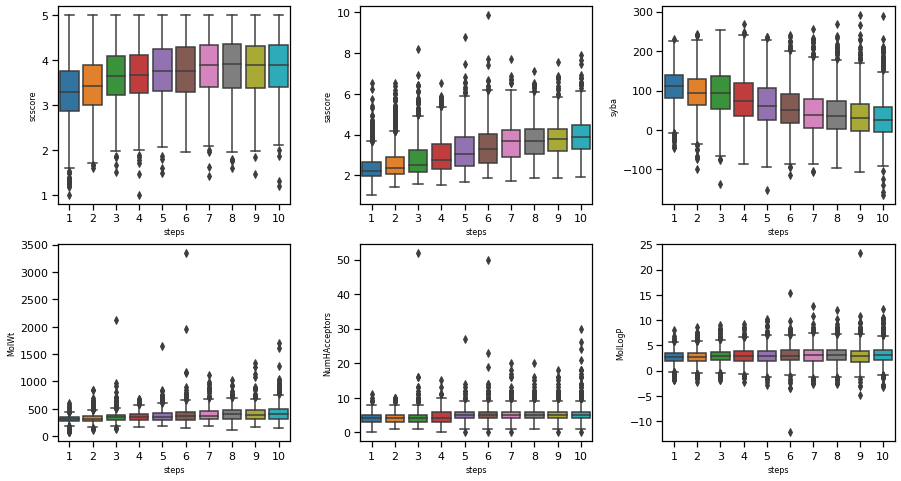

In [420]:
fig, axs = plt.subplots(ncols=3, nrows = 2,figsize=(15,8))
sns.set_context("notebook", rc={"font.size":8, "axes.titlesize":8, "axes.labelsize":8}) 
plt.subplots_adjust(wspace = 0.3)
sns.boxplot(x='number_of_steps', y='scscore', data=df_new_bin, ax=axs[0,0])
sns.boxplot(x='number_of_steps', y='sascore', data=df_new_bin, ax=axs[0,1])
sns.boxplot(x='number_of_steps', y='syba', data=df_new_bin, ax=axs[0,2])
sns.boxplot(x='number_of_steps', y='MolWt', data=df_new_bin, ax=axs[1,0])
sns.boxplot(x='number_of_steps', y='NumHAccept', data=df_new_bin, ax=axs[1,1])
sns.boxplot(x='number_of_steps', y='MolLogP', data=df_new_bin, ax=axs[1,2])
axs[0,0].set(xlabel="steps", ylabel = "scscore")
axs[0,1].set(xlabel="steps", ylabel = "sascore")
axs[0,2].set(xlabel="steps", ylabel = "syba")
axs[1,0].set(xlabel="steps", ylabel = "MolWt")
axs[1,1].set(xlabel="steps", ylabel = "NumHAcceptors")
axs[1,2].set(xlabel="steps", ylabel = "MolLogP")

In [421]:
d = df_new_bin[['steps_bins','target','number_of_steps','syba','sascore','scscore','MolWt','MolLogP','NumHAccept','NumHDonors']]

In [422]:
Q1 = d[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.25)
Q3 = d[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

syba          86.089005
sascore        1.387417
scscore        0.950093
MolWt         98.174500
MolLogP        1.759513
NumHAccept     2.000000
NumHDonors     1.000000
dtype: float64


In [423]:
df_drop_out = d[~((d < (Q1 - 1.5 * IQR)) | (d > (Q3 + 1.5 * IQR))).any(axis=1)]

/var/tmp/pbs.45214.lich-compute.vscht.cz/ipykernel_4724/3657922606.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_drop_out = d[~((d < (Q1 - 1.5 * IQR)) | (d > (Q3 + 1.5 * IQR))).any(axis=1)]


In [424]:
d.shape, df_drop_out.shape

((18176, 10), (16598, 10))

In [63]:
y_out = np.array(df_drop_out.steps_bins)
y_out_steps = np.array(df_drop_out.number_of_steps)
x_out = np.array(df_drop_out[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
s_out, p_out = best_param(x_out, y_out)

In [73]:
print_score(s_out, p_out)

Best MSE: 0.699
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 1000}


In [90]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=1000, max_features= 'sqrt')
score_df_out = cross_scoring(RFR, x_out, y_out)

In [74]:
s_out, p_out = best_param(x_out, y_out_steps)

In [77]:
print_score(s_out, p_out)

Best MSE: 4.601
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 800}


In [91]:
RFR = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=800, max_features= 'sqrt')
score_df_out_steps = cross_scoring(RFR, x_out, y_out_steps)

## My control

In [ ]:
y_con = np.array(df_con.steps_bins)
y_con_steps = np.array(df_con.number_of_steps)
x_con = np.array(df_con[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [ ]:
RFR = RandomForestRegressor(random_state=0)
score_df_con = cross_scoring(RFR, x_con, y_con)
score_df_con_steps = cross_scoring(RFR, x_con, y_con_steps)

## Prediction Denis data

In [101]:
df1 = pd.read_csv('data/Denis_final_data_after_pipeline.csv')
df1 = df1[df1.steps > 0]
df1 = df1[df1.steps <= 10]
df1 = df1.drop_duplicates(subset=['smiles'])
df1 = df1.drop(columns=['orig_smiles','orig_index','is_solved','pipeline_status','syba_score'])

In [102]:
mols1 = [Chem.MolFromSmiles(smile) for smile in df1.smiles]
df1['mol'] = mols1
df1['MolWt'] = df1.mol.apply(Descriptors.MolWt)
df1['MolLogP'] = df1.mol.apply(Descriptors.MolLogP)
df1['NumHAccept'] = df1.mol.apply(Descriptors.NumHAcceptors)
df1['NumHDonors'] = df1.mol.apply(Descriptors.NumHDonors)
df1['steps_bins'] = pd.cut(df1['steps'], [0,1,3,6,10], labels=False) #, labels=False

In [103]:
y1 = np.array(df1.steps_bins)
y1_steps = np.array(df1.steps)
x1 = np.array(df1[['syba', 'sa', 'sc', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])

In [104]:
score_df1 = cross_scoring(RFR, x1, y1)
score_df1_steps = cross_scoring(RFR, x1, y1_steps)

# Comparison

### Steps

In [105]:
d1 = pd.DataFrame.from_dict(score_df_con_steps)
d1['data']='control'
d2 = pd.DataFrame.from_dict(score_df_steps)
d2['data']='BS'
d3 = pd.DataFrame.from_dict(score_df_new_steps)
d3['data']='BS & F'
d4 = pd.DataFrame.from_dict(score_df_steps_bin)
d4['data']='BB'
d5 = pd.DataFrame.from_dict(score_df_steps_new_bin)
d5['data']='BB & F'
d6 = pd.DataFrame.from_dict(score_df_out_steps)
d6['data']='BB & F & DO'

In [106]:
frames = [d1,d2,d3,d4,d5,d6]
df_scores = pd.concat(frames)

In [107]:
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']
df_scores['test_RMSE'] = -1*df_scores['test_RMSE']

Text(0.5, 1.0, 'RMSE')

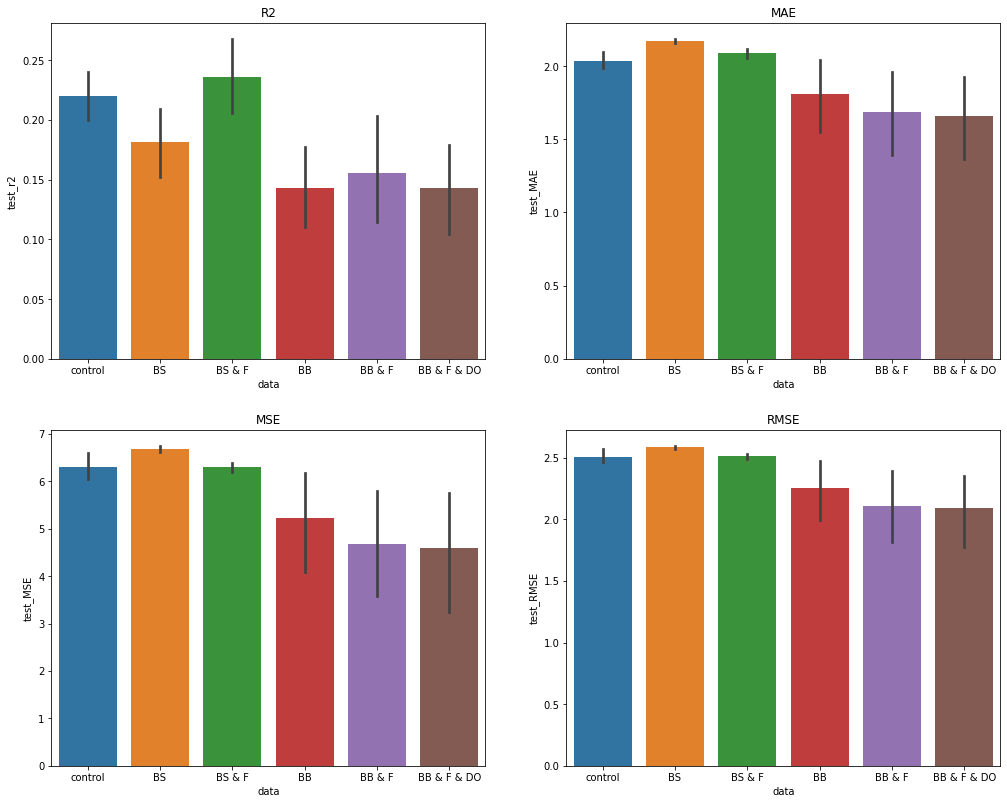

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.tight_layout(pad=5.0)
sns.barplot(ax=axes[0,0], data=df_scores, x="data", y="test_r2")
axes[0,0].set_title('R2')
#axes[0,0].tick_params(axis='x', rotation=45)
sns.barplot(ax=axes[0,1], data=df_scores, x="data", y="test_MAE")
axes[0,1].set_title('MAE')
sns.barplot(ax=axes[1,0], data=df_scores, x="data", y="test_MSE")
axes[1,0].set_title('MSE')
sns.barplot(ax=axes[1,1], data=df_scores, x="data", y="test_RMSE")
axes[1,1].set_title('RMSE')
#axes[1,0].grid()
#axes[0,1].grid()

In [123]:
print("MAE\nControl %0.03f" % df_scores[df_scores.data == 'control'].test_MAE.mean())
#print("Balanc_steps&filter %0.03f" % df_scores[df_scores.data == 'balanc_steps&filter'].test_MAE.mean())
print("Balanc_bin&filter %0.03f" % df_scores[df_scores.data == 'BB & F'].test_MAE.mean())
print("Balanc_bin&filter %0.03f" % df_scores[df_scores.data == 'BB & F & DO'].test_MAE.mean())

print("\nMSE\nControl %0.03f" % df_scores[df_scores.data == 'control'].test_MSE.mean())
#print("Balanc_steps&filter %0.03f" % df_scores[df_scores.data == 'balanc_steps&filter'].test_MSE.mean())
print("Balanc_bin&filter %0.03f" % df_scores[df_scores.data == 'BB & F'].test_MSE.mean())
print("Balanc_bin&filter %0.03f" % df_scores[df_scores.data == 'BB & F & DO'].test_MSE.mean())

MAE
Control 2.033
Balanc_bin&filter 1.684
Balanc_bin&filter 1.656

MSE
Control 6.306
Balanc_bin&filter 4.674
Balanc_bin&filter 4.601


### Bins

In [274]:
d1 = pd.DataFrame.from_dict(score_df_con)
d1['data']='control'
d2 = pd.DataFrame.from_dict(score_df)
d2['data']='BS'
d3 = pd.DataFrame.from_dict(score_df_new)
d3['data']='BS & F'
d4 = pd.DataFrame.from_dict(score_df_bin)
d4['data']='BB '
d5 = pd.DataFrame.from_dict(score_df_new_bin)
d5['data']='BB & F'
d6 = pd.DataFrame.from_dict(score_df_out)
d6['data']='BB & F & DO'
frames = [d1, d2, d3, d4, d5, d6]
df_bins_scores = pd.concat(frames)

In [275]:
df_bins_scores['test_MSE'] = -1*df_bins_scores['test_MSE']
df_bins_scores['test_MAE'] = -1*df_bins_scores['test_MAE']
df_bins_scores['test_RMSE'] = -1*df_bins_scores['test_RMSE']

Text(0.5, 1.0, 'RMSE')

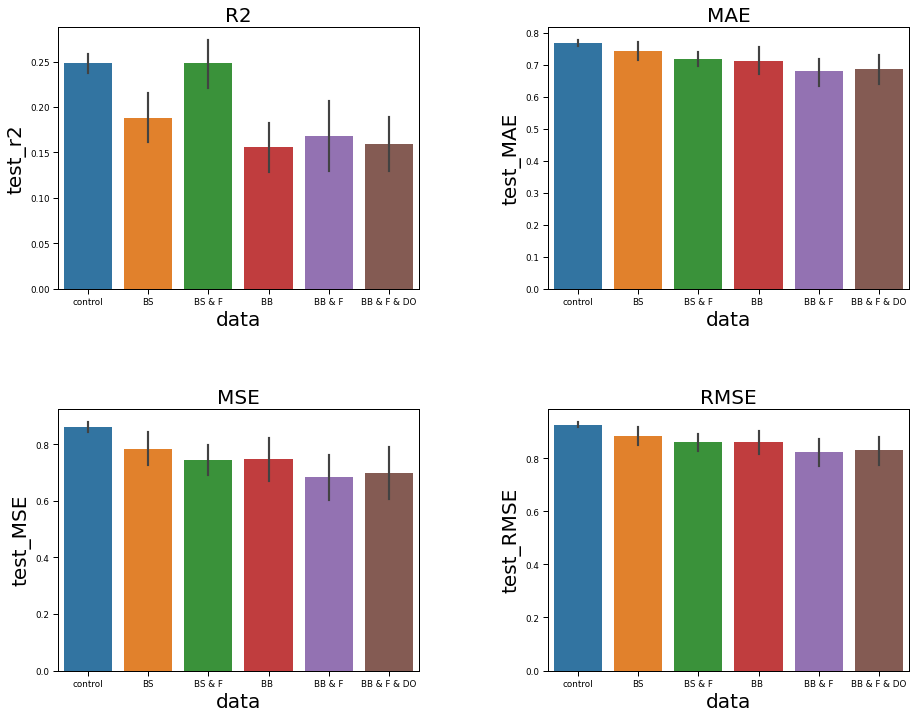

In [276]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.tight_layout(pad=5.0)
sns.barplot(ax=axes[0,0], data=df_bins_scores, x="data", y="test_r2")
axes[0,0].set_title('R2')
sns.barplot(ax=axes[0,1], data=df_bins_scores, x="data", y="test_MAE")
axes[0,1].set_title('MAE')
sns.barplot(ax=axes[1,0], data=df_bins_scores, x="data", y="test_MSE")
axes[1,0].set_title('MSE')
sns.barplot(ax=axes[1,1], data=df_bins_scores, x="data", y="test_RMSE")
axes[1,1].set_title('RMSE')

In [114]:
print("MAE\nControl %0.03f" % df_bins_scores[df_bins_scores.data == 'control'].test_MAE.mean())
#print("Balanc_steps&filter %0.03f" % df_bins_scores[df_bins_scores.data == 'balanc_steps&filter'].test_MAE.mean())
print("Balanc_bin&filter %0.03f" % df_bins_scores[df_bins_scores.data == 'BB & F'].test_MAE.mean())
print("Balanc_bin&filter&drop_duplicates %0.03f" % df_bins_scores[df_bins_scores.data == 'BB & F & DO'].test_MAE.mean())

print("\nMSE\nControl %0.03f" % df_bins_scores[df_bins_scores.data == 'control'].test_MSE.mean())
#print("Balanc_steps&filter %0.03f" % df_bins_scores[df_bins_scores.data == 'balanc_steps&filter'].test_MSE.mean())
print("Balanc_bin&filter %0.03f" % df_bins_scores[df_bins_scores.data == 'BB & F'].test_MSE.mean())
print("Balanc_bin&filter&drop_duplicates %0.03f" % df_bins_scores[df_bins_scores.data == 'BB & F & DO'].test_MSE.mean())

MAE
Control 0.771
Balanc_bin&filter 0.680
Balanc_bin&filter&drop_duplicates 0.686

MSE
Control 0.878
Balanc_bin&filter 0.686
Balanc_bin&filter&drop_duplicates 0.699


## Visualization

In [116]:
pca = PCA()
df2 = df_new_bin[['syba', 'sascore', 'scscore','MolWt','MolLogP','NumHAccept','NumHDonors']]
scaled_df_2 = StandardScaler().fit_transform(df2) 
pca_fit = pca.fit(scaled_df_2)

In [117]:
pca_df = pd.DataFrame(data = scaled_df_2, 
                      columns = [f"PC {i}" for i in range(1,len(df2.columns)+1)])

shape:  (12365, 7)


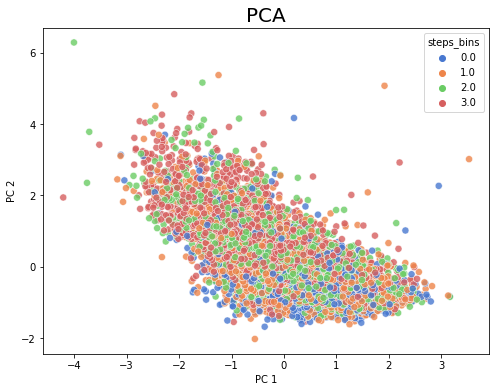

In [119]:
plt.figure(figsize=(8,6))
#sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16}) 
plot = sns.scatterplot(data=pca_df, x="PC 1", y="PC 2", hue=df_new_bin.steps_bins, 
                       alpha=0.8, palette='muted', s=50).set_title('PCA', fontsize=20)
#plt.legend(fontsize='16', title_fontsize='16')
print('shape: ', scaled_df_2.shape)

In [120]:
fps_tsne = TSNE(n_components=2, perplexity=50, init='pca', 
                learning_rate='auto', random_state=1).fit_transform(scaled_df_2)

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


shape:  (12365, 2)


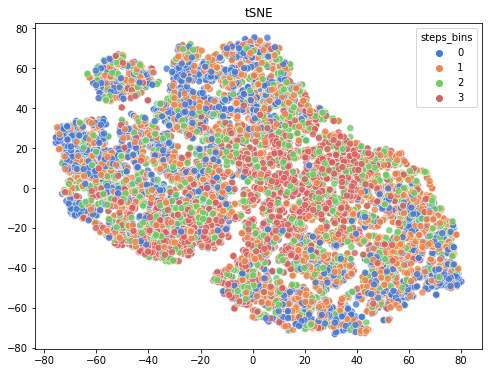

In [121]:
plt.figure(figsize=(8,6))
plot = sns.scatterplot(x=fps_tsne[:,0], y=fps_tsne[:,1], hue=df_new_bin['steps_bins'],
                       palette='muted',alpha=0.8,s=50).set_title('tSNE')
#plot = sns.scatterplot(x=fps_tsne[:,0], y=fps_tsne[:,1], hue=df['steps_bins'], palette='muted', alpha=0.8, s=50).set_title(
#    'tSNE', fontsize=20)
#plt.legend(fontsize='16', title_fontsize='16')
print('shape: ', fps_tsne.shape)

# Control vs the best

In [124]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay

In [198]:
X_train, X_test, y_train, y_test = train_test_split(x_new_bin, y_new_steps_bin, random_state=1)

In [199]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x_out, y_out_steps, random_state=1)

In [200]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_con, y_con_steps, random_state=1)

In [178]:
RFR = RandomForestRegressor(random_state=0)

In [129]:
RFR_fit = RFR.fit(X_train, y_train)
predict = RFR_fit.predict(X_test)
predict_r = np.array([round(y) for y in predict])

In [130]:
RFR_fit1 = RFR.fit(X_train1, y_train1)
predict1 = RFR_fit1.predict(X_test1)
predict_r1 = np.array([round(y) for y in predict1])

In [179]:
RFR_fit2 = RFR.fit(X_train2, y_train2)
predict2 = RFR_fit1.predict(X_test2)
predict_r2 = np.array([round(y) for y in predict2])

In [196]:
def print_metrics(y_test, predict, predict_r):
    print('f1: %0.3f' % f1_score(y_test, predict_r, average='weighted'))
    print('Accuracy: %0.3f' % accuracy_score(y_test, predict_r))
    #print('Recall: %0.3f' % recall_score(y_test, predict_r, average='weighted'))
    #print('Precision: %0.3f' % precision_score(y_test, predict_r, average='weighted', zero_division=0))
    print('MSE: %0.3f' %  mean_squared_error(y_test, predict))
    print('MAE: %0.3f' % mean_absolute_error(y_test, predict))
    print('R2: %0.3f' % r2_score(y_test, predict))

In [201]:
print("Balanced bins filtered data")
print_metrics(y_test, predict, predict_r)
print("\nBalanced bins filtered data without outliers")
print_metrics(y_test1, predict1, predict_r1)
print("\nControl")
print_metrics(y_test2, predict2, predict_r2)

Balanced bins filtered data
f1: 0.186
Accuracy: 0.193
MSE: 4.810
MAE: 1.698
R2: 0.408

Balanced bins filtered data without outliers
f1: 0.190
Accuracy: 0.195
MSE: 4.652
MAE: 1.655
R2: 0.366

Control
f1: 0.124
Accuracy: 0.145
MSE: 5.997
MAE: 1.961
R2: 0.245


Balanced bins filtered data without outliers


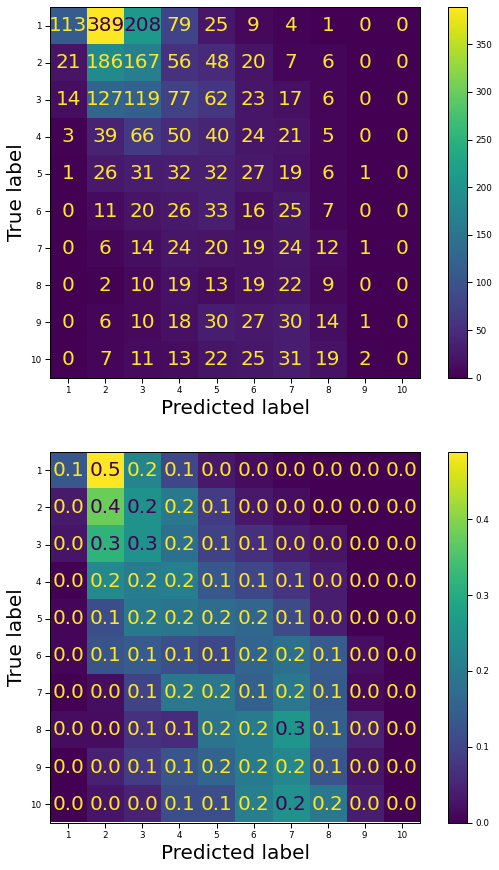

In [220]:
fig, ax = plt.subplots(2,1,figsize=(10, 15))
print("Balanced bins filtered data without outliers")
ConfusionMatrixDisplay.from_predictions(y_test1, predict_r1, ax=ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, predict_r, ax=ax[1], normalize = 'true', values_format='.1f')
plt.show()

Control


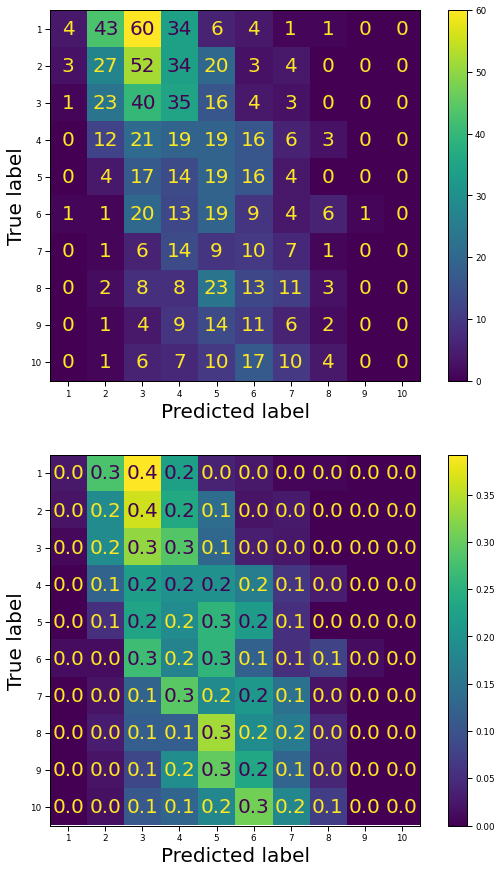

In [222]:
fig, ax = plt.subplots(2,1,figsize=(10, 15))
print("Control")
ConfusionMatrixDisplay.from_predictions(y_test2, predict_r2, ax=ax[0])
ConfusionMatrixDisplay.from_predictions(y_test2, predict_r2, ax=ax[1], normalize = 'true', values_format='.1f')
plt.show()

#

In [500]:
d1 = pd.DataFrame.from_dict(score_df_con_steps)
d1['Data']='data'
d1['data_group'] = 'control'
d2 = pd.DataFrame.from_dict(score_df_steps)
d2['Data']='Data'
d2['data_group'] = 'Balanced steps'
d3 = pd.DataFrame.from_dict(score_df_new_steps)
d3['Data']='Data with filter'
d3['data_group'] = 'Balanced steps'
d4 = pd.DataFrame.from_dict(score_df_steps_bin)
d4['Data']='Data'
d4['data_group'] = 'Balanced groups'
d5 = pd.DataFrame.from_dict(score_df_steps_new_bin)
d5['Data']='Data with filter'
d5['data_group'] = 'Balanced groups'
d6 = pd.DataFrame.from_dict(score_df_out_steps)
d6['Data']='data & filter & rem outliers'
d6['data_group'] = 'Balanced groups'
d7 = pd.DataFrame.from_dict(score_df_out_steps2)
d7['Data']='data & filter & rem outliers'
d7['data_group'] = 'Balanced steps'
frames = [d2, d3, d4, d5]
df_scores = pd.concat(frames)
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']

Text(0.5, 32.5, ' ')

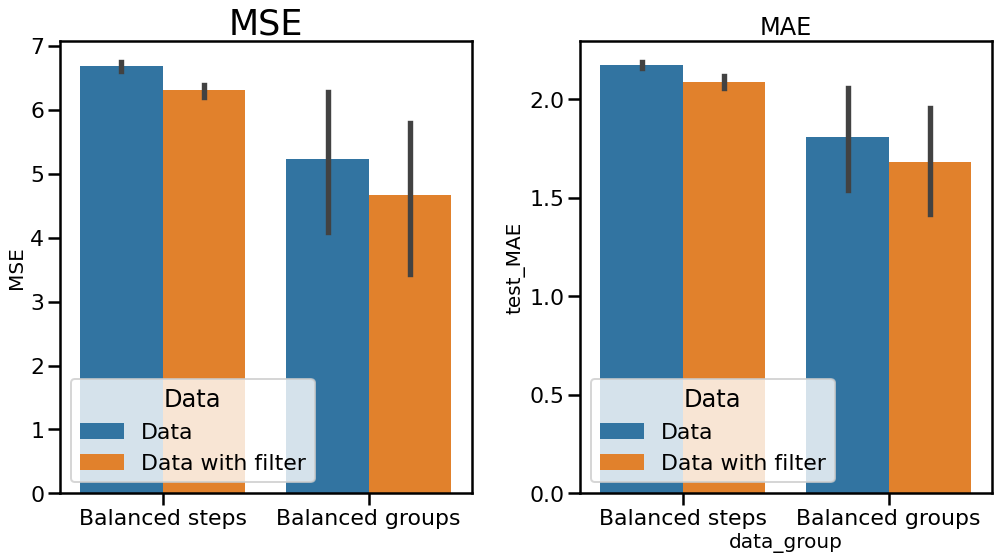

In [504]:
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
fig.tight_layout(pad=2.0)
sns.barplot(ax=axes[0], data=df_scores, x="data_group", y="test_MSE",  hue="Data")
axes[0].set_title('MSE', fontsize=35)
sns.barplot(ax=axes[1], data=df_scores, x="data_group", y="test_MAE",  hue="Data")
axes[1].set_title('MAE', fontsize=24)
axes[0].set_ylabel('MSE',fontsize=20)
axes[0].set_xlabel(' ',fontsize=20)

In [477]:
d1 = pd.DataFrame.from_dict(score_df_con_steps)
d1['data_group'] = 'Primitive'
d4 = pd.DataFrame.from_dict(score_df_steps_bin)
d4['data_group'] = 'Balanced\nGroups'
d5 = pd.DataFrame.from_dict(score_df_steps_new_bin)
d5['data_group'] = 'Balanced\nGroups\n   Filter    '
d6 = pd.DataFrame.from_dict(score_df_out_steps)
d6['data_group'] = 'Balanced Groups\n  Filter    \n Removed Outliers'
frames = [d1, d4, d5, d6]
df_scores = pd.concat(frames)
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']

Text(0.5, 1.0, 'MSE')

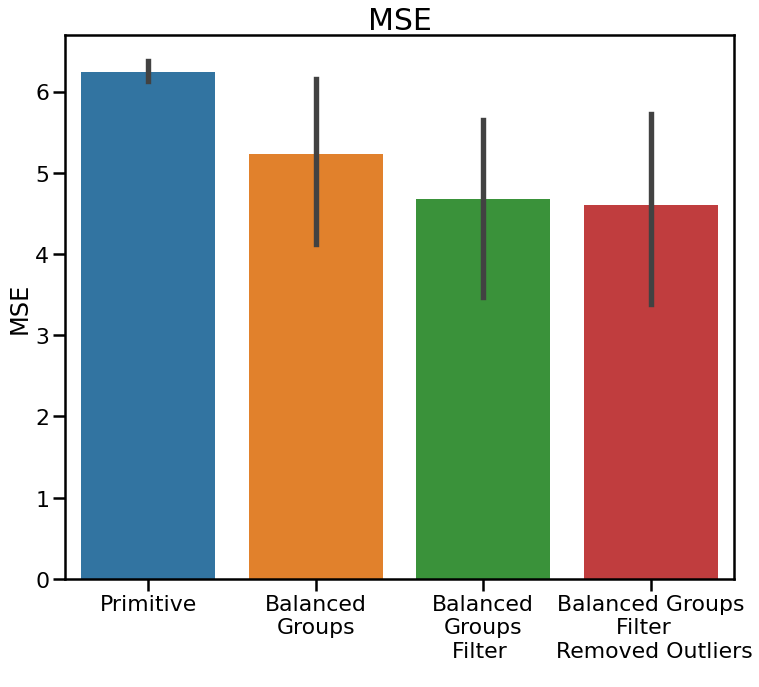

In [498]:
sns.set_context("poster", rc={"font.size":18, "axes.titlesize":18, "axes.labelsize":18}) 
plt.figure(figsize=(12,10))
g = sns.barplot(data=df_scores, x="data_group", y="test_MSE")
g.set_xlabel(' ',fontsize=16)
g.set_ylabel('MSE',fontsize=24)
g.set_title('MSE', fontsize=30)
#plt.xticks(size = 16)

In [505]:
#fig = g.get_figure()
fig.savefig('mse.png')

In [409]:
df_scores['test_MAE'][df_scores['data_group'] == 'BalanBins\n  Filter    \n RemOut  '].mean()

1.6559782239835479

In [410]:
df_scores['test_MAE'][df_scores['data_group'] == 'Primitive'].mean()

2.0259746235743625

In [412]:
df_scores['test_MSE'][df_scores['data_group'] == 'BalanBins\n  Filter    \n RemOut  '].mean()

4.601215818155981

In [411]:
df_scores['test_MSE'][df_scores['data_group'] == 'Primitive'].mean()

6.2453141256042155

In [302]:
d1 = pd.DataFrame.from_dict(score_df_con)
d1['data']='data'
d1['data_group'] = 'control'
d2 = pd.DataFrame.from_dict(score_df)
d2['data']='data'
d2['data_group'] = 'balanced steps'
d3 = pd.DataFrame.from_dict(score_df_new)
d3['data']='data_with_filter'
d3['data_group'] = 'balanced steps'
d4 = pd.DataFrame.from_dict(score_df_bin)
d4['data']='data'
d4['data_group'] = 'balanced bins'
d5 = pd.DataFrame.from_dict(score_df_new_bin)
d5['data']='data_with_filter'
d5['data_group'] = 'balanced bins'
d6 = pd.DataFrame.from_dict(score_df_out)
d6['data']='data & filter & rem outliers'
d6['data_group'] = 'balanced bins'
d7 = pd.DataFrame.from_dict(score_df_out2)
d7['data']='data & filter & rem outliers'
d7['data_group'] = 'balanced steps'

frames = [d1,d2, d3, d4, d5, d6, d7]
df_bins_scores = pd.concat(frames)
df_bins_scores['test_MSE'] = -1*df_bins_scores['test_MSE']
df_bins_scores['test_MAE'] = -1*df_bins_scores['test_MAE']

Text(0.5, 1.0, 'MSE')

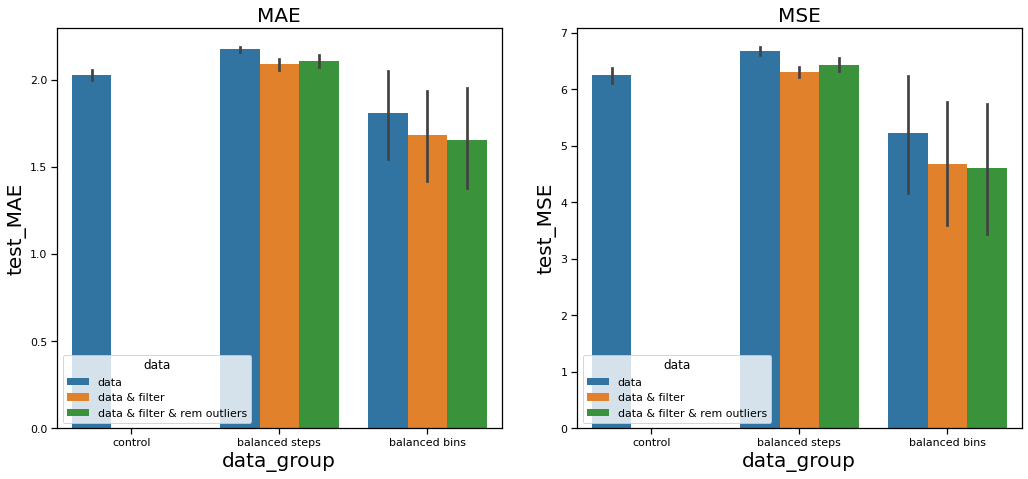

In [303]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
fig.tight_layout(pad=2.0)
sns.barplot(ax=axes[0], data=df_scores, x="data_group", y="test_MAE",  hue="data")
axes[0].set_title('MAE')
sns.barplot(ax=axes[1], data=df_scores, x="data_group", y="test_MSE",  hue="data")
axes[1].set_title('MSE', fontsize=20)

In [171]:
fig.savefig('filter bins.png')

# AUC

In [147]:
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [148]:
y = label_binarize(y_new_bin, classes=[0, 1, 2, 3])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(x_new_bin, y, random_state=1)
classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True, random_state=1))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [149]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

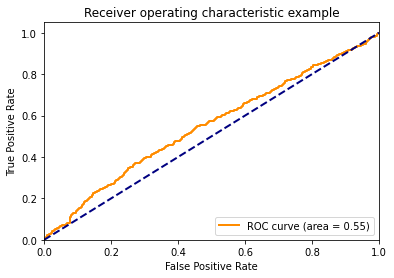

In [150]:
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc[2])
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [151]:
## Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [152]:
roc_auc

{0: 0.7945893779010095,
 1: 0.6063250448306352,
 2: 0.5495384220683593,
 3: 0.8499687712723776,
 'micro': 0.7352209055962137,
 'macro': 0.7003358606822112}

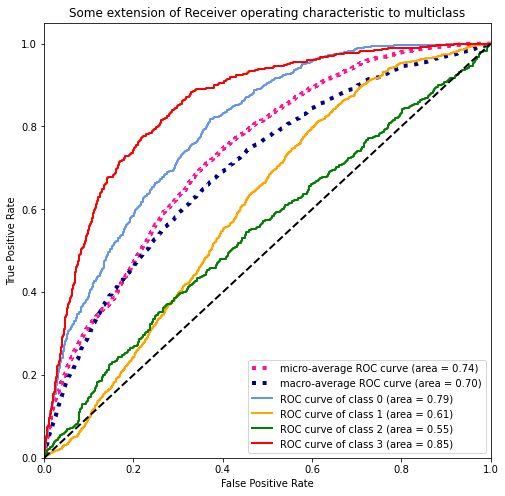

In [153]:
# Plot all ROC curves
plt.figure(figsize = (8,8))
plt.plot(fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4)

colors = cycle(["cornflowerblue", "orange", "green",'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

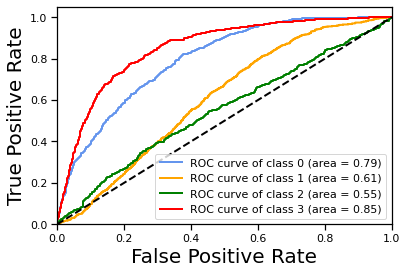

In [305]:
colors = cycle(["cornflowerblue", "orange", "green",'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [427]:
len(df_new_bin)

18176

In [426]:
filepath = Path('MVI_data_all_filtered.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_new_bin.to_csv(filepath, index=False) 